# Adaptive Lasso and stability selection

In [1]:
import numpy as np
from sklearn.linear_model import Lasso, LassoCV
from sklearn.utils.random import sample_without_replacement
from joblib import Parallel, delayed
import matplotlib.pylab as plt
from time import time
import seaborn as sns

from sklearn.linear_model import Ridge
from matplotlib import rc, font_manager

from sparsity_estimators import Adaptive_Lasso_SS, ir_cond,ir_condAL,ir_condrAL

%load_ext autoreload
%autoreload 2

In [2]:
font_size=24
ticks_font = font_manager.FontProperties(size=font_size)


# loading some noiseless data

In [3]:

theta = np.load('../data/mixed_kdv_theta_GT.npy')
dt    = np.load('../data/mixed_kdv_dt_GT.npy')

theta_o = theta
dt_o = dt

In [4]:
theta.shape

(2, 10000, 12)

In [5]:
sns.set(font_scale=2)
sns.set_style("white")



In [6]:
name_feats = [r'$1$', r'$u_x$', '$u_{xx}$', '$u_{xxx}$', '$u$', '$u u_{x}$', '$u u_{xx}$', '$u u_{xxx}$', '$u^2$', '$u^2 u_{x}$', '$u^2 u_{xx}$', '$u^2 u_{xxx}$']


In [20]:
width = 345

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 18,
    "font.size": 14,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

plt.rcParams.update(tex_fonts)

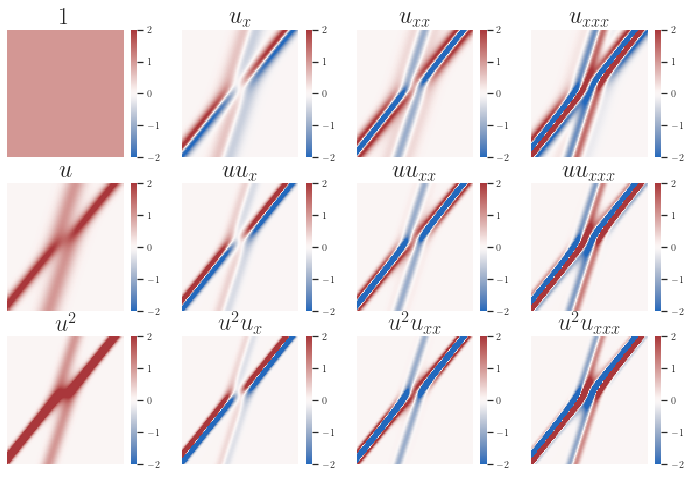

In [21]:
fig,ax = plt.subplots(3,4,sharey='row',figsize=(12,8))

lib=0
for i in range(3):
    for j in range(4):

        bx = sns.heatmap(theta_o[0,:,lib].reshape(100,100).T,ax=ax[i,j],vmin=-2,vmax=2,cmap=sns.color_palette("vlag", as_cmap=True),cbar=True)
        bx.invert_yaxis()
        bx.set_yticks([])
        bx.set_xticks([])
        bx.set_title(name_feats[lib])
        lib+=1


plt.savefig("figures/lib_kdv.png", bbox_inches='tight')

In [9]:
sub = np.random.randint(0,theta.shape[1],2000)
theta = theta[:,sub,:]
dt    = dt[:,sub,:]

GT = [3,5]

# normalizing dt and library time wise
normed_dt = dt/np.linalg.norm(dt,axis=1,keepdims=True)
normed_theta = theta/np.linalg.norm(theta,axis=1,keepdims=True)

In [10]:
theta.shape

(2, 2000, 12)

In [11]:
irrelevant_terms = np.setdiff1d(np.arange(0,theta.shape[2]),np.array(GT)).tolist()
rel_feat_name   = (np.array(name_feats)[GT]).tolist()
irr_feats_names = (np.array(name_feats)[irrelevant_terms]).tolist()

# subselecting a single 2 solitons experiment

In [12]:
X = normed_theta[0,:,:]
y = normed_dt[0,:,:]

### verifying the weak IRC and correlations

In [13]:
mLasso = ir_cond(X,GT)
mLasso[1].max()

1.7041692306872838

In [14]:
mAdaLasso =ir_condAL(X,y,GT)
mAdaLasso[1].max()

2.140466763915758e-14

# Lasso

In [15]:
clf = LassoCV(fit_intercept=False,max_iter=1e4).fit(X,y.ravel())
clf.coef_

array([ 0.        , -0.03057429,  0.        , -0.94192982, -0.        ,
       -1.76117502,  0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        ])

In [16]:
betahat = np.array([Lasso(alpha=alpha,fit_intercept=False,max_iter=1e4).fit(X,y.ravel()).coef_ for alpha in clf.alphas_])

# adaptive lasso

In [17]:
def minimal_adaptive_Lasso_ridge(X,y,alphas,super_power:float=2):
    
    def coeffs(alpha):

        n_samples, n_features = X.shape
    
        # initial weights
        
        weights = (np.abs(Ridge(alpha=1e-10,fit_intercept=False).fit(X, y).coef_).ravel())**super_power        
        X_w = X * weights[np.newaxis, :]
        clf = Lasso(alpha=alpha, fit_intercept=False)
        clf.fit(X_w, y)
        coef_ = clf.coef_ * weights

        return coef_
    
    betasAL = Parallel(n_jobs=-1)(delayed(coeffs)(alpha) for i, alpha in enumerate(alphas))    
    
    return betasAL

In [18]:
betasAL_ridge = minimal_adaptive_Lasso_ridge(normed_theta[0,:,:],normed_dt[0,:,:],clf.alphas_)

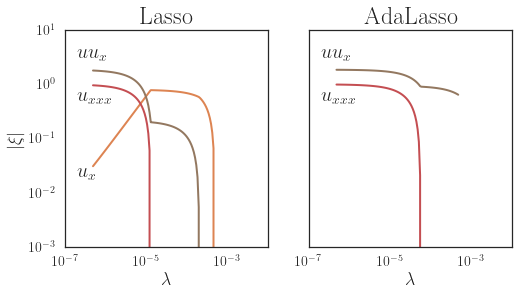

In [19]:
fig,ax = plt.subplots(1,2,sharey='row',figsize=(8,4))

ax[0].plot(clf.alphas_,np.abs(betahat),linewidth=2)

ax[1].plot(clf.alphas_,np.abs(betasAL_ridge),linewidth=2)


for i in [0,1]:
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlim([1e-7,1e-2])
    ax[i].set_ylim([1e-3,1e1])
    ax[i].set_xlabel(r'$\lambda$')#, fontsize=font_size)

    

ax[0].set_ylabel(r'$| \xi |$ ')#, fontsize=font_size)
ax[0].set_title('Lasso')#, fontsize=font_size)
ax[1].set_title('AdaLasso')#, fontsize=font_size)

ax[0].text(2e-7,2e-2,r'$u_x$', fontsize=20)
ax[0].text(2e-7,0.5,r'$u_{xxx}$', fontsize=20)
ax[0].text(2e-7,3,r'$uu_x$', fontsize=20)


ax[1].text(2e-7,0.5,r'$u_{xxx}$', fontsize=20)
ax[1].text(2e-7,3,r'$uu_x$', fontsize=20)


#ax[1].legend(name_feats,prop={'size': 16},bbox_to_anchor=(1, 1))

plt.savefig("figures/lasso_adaLasso.pdf", bbox_inches='tight')